# Predicting Metabolic Syndrome


#### Kevin Ridge

This data comes from the National Center for Statistics.

- link to data.world source: https://data.world/informatics-edu/metabolic-syndrome-prediction

In [85]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, \
ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, \
make_column_selector
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

In [2]:
# Load data and display frame
path = 'https://query.data.world/s/t3rpnwlmgmnjo32ig43eanarjmwdxt?dws=00000'
df = pd.read_csv(path)
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


In [28]:
# Create copy of data
df1 = df.copy()

In [187]:
df4 = df3.copy()

## **Data Inspection**

In [3]:
# Display basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               2401 non-null   int64  
 1   Age                2401 non-null   int64  
 2   Sex                2401 non-null   object 
 3   Marital            2193 non-null   object 
 4   Income             2284 non-null   float64
 5   Race               2401 non-null   object 
 6   WaistCirc          2316 non-null   float64
 7   BMI                2375 non-null   float64
 8   Albuminuria        2401 non-null   int64  
 9   UrAlbCr            2401 non-null   float64
 10  UricAcid           2401 non-null   float64
 11  BloodGlucose       2401 non-null   int64  
 12  HDL                2401 non-null   int64  
 13  Triglycerides      2401 non-null   int64  
 14  MetabolicSyndrome  2401 non-null   object 
dtypes: float64(5), int64(6), object(4)
memory usage: 281.5+ KB


- There are missing values in Marital, Income, WaistCirc, and BMI Columns.

In [4]:
# Display the number of rows and columns
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')

There are 2401 rows, and 15 columns.


In [5]:
# Check numerical columns
df.describe()

,seqn,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
count,2401.000000,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,67030.674302,48.691795,4005.253940,98.307254,28.702189,0.154102,43.626131,5.489046,108.247813,53.369429,128.125364
std,2823.565114,17.632852,2954.032186,16.252634,6.662242,0.422780,258.272829,1.439358,34.820657,15.185537,95.322477
min,62161.000000,20.000000,300.000000,56.200000,13.400000,0.000000,1.400000,1.800000,39.000000,14.000000,26.000000
25%,64591.000000,34.000000,1600.000000,86.675000,24.000000,0.000000,4.450000,4.500000,92.000000,43.000000,75.000000
50%,67059.000000,48.000000,2500.000000,97.000000,27.700000,0.000000,7.070000,5.400000,99.000000,51.000000,103.000000
75%,69495.000000,63.000000,6200.000000,107.625000,32.100000,0.000000,13.690000,6.400000,110.000000,62.000000,150.000000
max,71915.000000,80.000000,9000.000000,176.000000,68.700000,2.000000,5928.000000,11.300000,382.000000,156.000000,1562.000000


- The seqn column appears to be a unique identification number. I will drop this column during the train test split. With so many irrelevant unique values, seqn will not effect model training. 
- WaistCirc has possible outlier of 176.0 cm. I will test between the 75% and max to make sure. 
- Albuinuria has 0.0 for minimum and everthing between to the max. I will have to inspect this column.
- UrAlbCr has a rather high max which might be an outlier.
- 382 for a fasting BloodGlucose is very high. 
- The max in Triglycerides also appears to be an outlier. 
- For now, I will leave the higher numbers in this dataset as possible outliers. I will study further to see if these are realistic numbers. 

In [6]:
# Check the categorical columns
df.describe(include='object')

,Sex,Marital,Race,MetabolicSyndrome
count,2401,2193,2401,2401
unique,2,5,6,2
top,Female,Married,White,No MetSyn
freq,1211,1192,933,1579


- No outstanding notes at first glance. 

## **Data Cleaning**

In [7]:
# Display total number of duplicates
df.duplicated().sum()

0

- No duplicate rows to drop. 

In [8]:
# Display names of categorical columns and create a varible
dtypes = df.dtypes
typ_obj = dtypes[dtypes== 'object'].index
typ_obj

Index(['Sex', 'Marital', 'Race', 'MetabolicSyndrome'], dtype='object')

- No inconsistentcies here.

In [105]:
# Display values for categorical columns
for col in typ_obj:
  print(f'-Column= {col}')
  print(df[col].value_counts(dropna=False))
  print('\n')

-Column= Sex
Female    1211
Male      1190
Name: Sex, dtype: int64


-Column= Marital
Married      1192
Single        498
Divorced      242
NaN           208
Widowed       166
Separated      95
Name: Marital, dtype: int64


-Column= Race
White          933
Black          548
Asian          349
Hispanic       257
MexAmerican    253
Other           61
Name: Race, dtype: int64


-Column= MetabolicSyndrome
0    1579
1     822
Name: MetabolicSyndrome, dtype: int64




- Aside form the NaN entries for Marital, no other inconsistentcies here.

In [10]:
# Find how many measurements are above 135 centimeters for waist circumference
cm = 135
count = (df['WaistCirc'] > cm).sum()
print(f'There are {count} values between 135 cm and the max of 176 cm.')

There are 63 values between 135 cm and the max of 176 cm.


In [11]:
# Find how many measurements are above 150 centimeters for waist circumference
cm2 = 150
count2 = (df['WaistCirc'] > cm2).sum()
print(f'There are {count2} values between 155 cm and the max of 176 cm.')

There are 10 values between 155 cm and the max of 176 cm.


- There are some outlier values but they are realistic for this data frame. 

In [12]:
# Find out why there are values of 0 in Albuminuria column
df.value_counts('Albuminuria')

Albuminuria
0    2089
1     254
2      58
dtype: int64

- The zero values in the Albuminuria column are fine. 
- Albuminuria is an ordinal feature.
- 0 is normal range, 1 is elevated, and 2 is high.

In [13]:
# Display missing values for each feature
print(df.isna().sum())

seqn                   0
Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64


In [32]:
# Display missing values by feature percentage
df.isnull().mean() * 100

seqn                 0.000000
Age                  0.000000
Sex                  0.000000
Marital              8.663057
Income               4.872970
Race                 0.000000
WaistCirc            3.540192
BMI                  1.082882
Albuminuria          0.000000
UrAlbCr              0.000000
UricAcid             0.000000
BloodGlucose         0.000000
HDL                  0.000000
Triglycerides        0.000000
MetabolicSyndrome    0.000000
dtype: float64

- Adressing the missing data:
 - I will not drop any row nor column, this would lead to data loss. 
 - All imputations for missing values will take place after the train and test data split to prevent data leakage. 
 - Marital can be filled with "unknown" for missing values. With five possible choices, I don't want to create correlations by imputing 208 values with one of those choices.
 - Income will be filled with the median strategy.   
 - I could use median or mean strategies for WaistCirc and BMI. However, I feel using either could slightly distort the data. I will inspect further and possibly use "unknown" imputation since the missing values are so few. 

## **Exploratory analyisis**

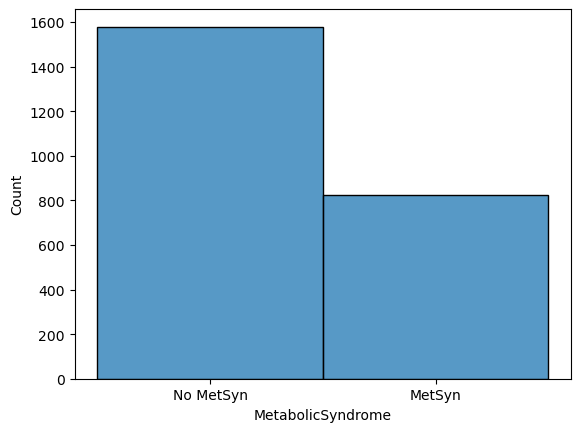

In [14]:
# Univariate plot for MetabolicSyndrome
sns.histplot(df['MetabolicSyndrome']);

- Visual shows the positive and negative counts for MetabolicSyndrome. 

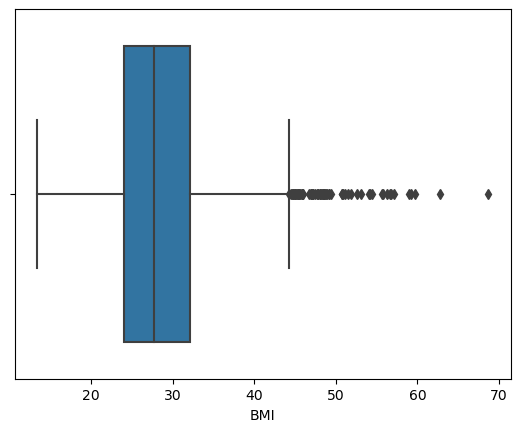

In [15]:
# Boxplot visual for Body Mass Index 
sns.boxplot(x=df['BMI']);

- Most of the participants have between 24 and 33 BMI. 

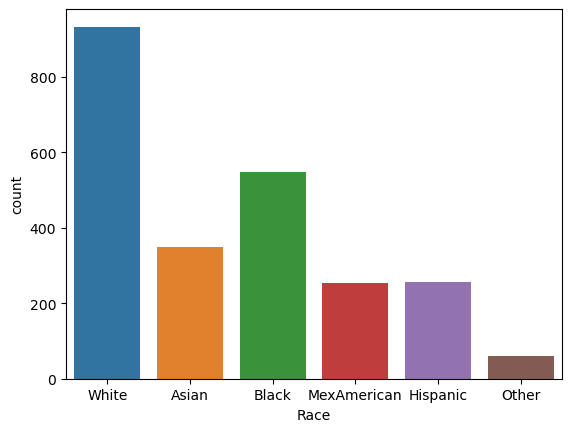

In [16]:
# Visualize what races participated in the study with a countplot
sns.countplot(x=df['Race']);

- Visual shows number of each race participating in this study. Since there is not an even balance of participants, this data will unlikely link genetic predispositions to develop metabolic syndrome based on race.

## Part 3

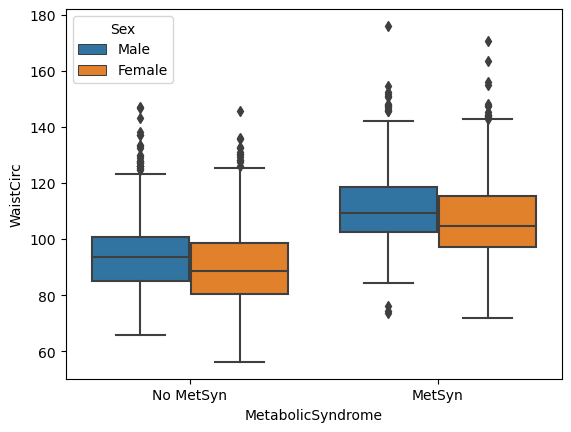

In [17]:
# Boxplot display for waist circumference and sex
sns.boxplot(data=df, x='MetabolicSyndrome', y='WaistCirc', hue='Sex');

- A higher waist circumference is direcrly related to developing metabolic syndrome but not much difference for male or female.

In [18]:
# In order to display heat map correlation for my target, MetabolicSyndrome has to be changed to binary intergers
df['MetabolicSyndrome'].replace({'No MetSyn': '0'}, inplace=True)
df['MetabolicSyndrome'].replace({'MetSyn': '1'}, inplace=True)
df['MetabolicSyndrome'] = df['MetabolicSyndrome'].astype(int)
df['MetabolicSyndrome'].value_counts()

0    1579
1     822
Name: MetabolicSyndrome, dtype: int64

C:\Users\ridge\AppData\Local\Temp\ipykernel_23432\2237087295.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


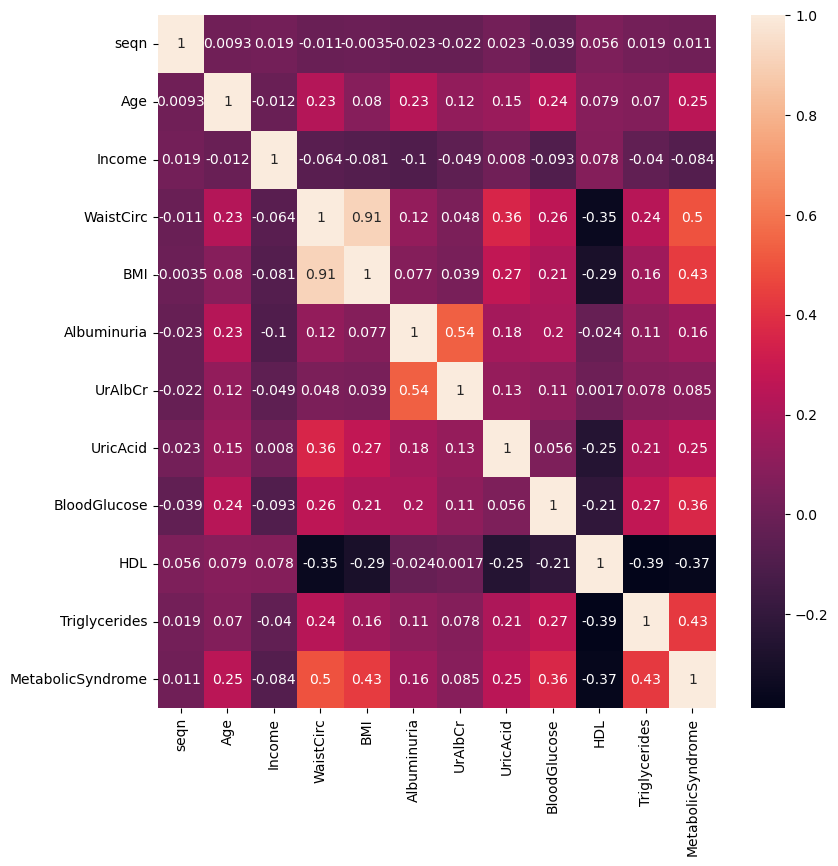

In [19]:
# Display heatmap
corr = df.corr()
plt.figure(figsize = (9, 9))
sns.heatmap(corr, annot=True);

- There are no very high correlations between features and target. The highest is WaistCirc, followed by Triglycerides, BMI. Major note is that HDL has several negative correlations with attributes thought to increase metabolic syndrome. Waist Circumference and BMI have the highest correlation which is pretty obvious. 

### **The following scatterplots further display relationships between the features and target.**

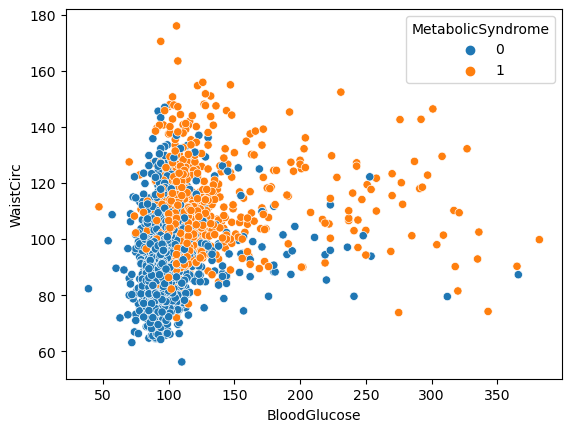

In [20]:
sns.scatterplot(data=df, x='BloodGlucose', y = 'WaistCirc', hue= 'MetabolicSyndrome');

#### Fasting blood glucose numbers above 100 have many more positive metabolic syndrome cases. 

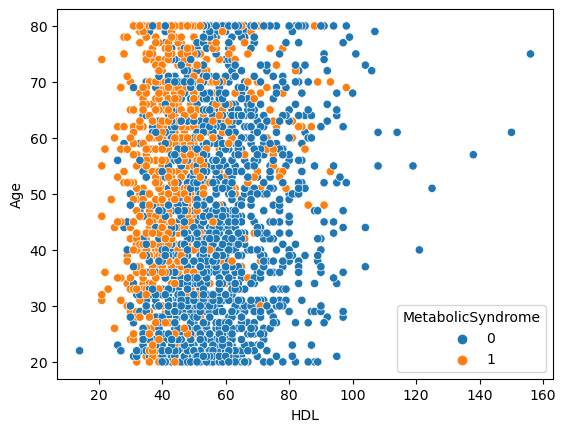

In [22]:
sns.scatterplot(data=df, x='HDL', y = 'Age', hue= 'MetabolicSyndrome');

#### A large number of participants have positive metabolic syndrome when their HDL is measured under 60.

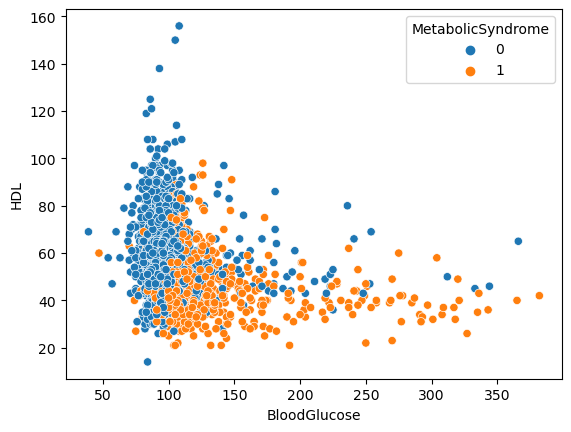

In [21]:
sns.scatterplot(data=df, x='BloodGlucose', y = 'HDL', hue= 'MetabolicSyndrome');

#### Most of the participants under 60 HDL and above 100 Blood Glucose have metabolic syndrome

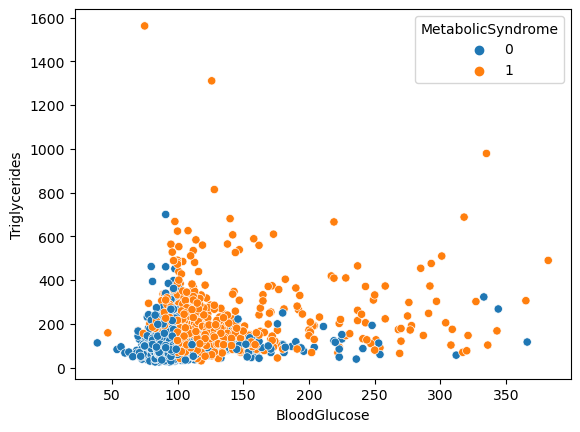

In [23]:
sns.scatterplot(data=df, x='BloodGlucose', y = 'Triglycerides', hue= 'MetabolicSyndrome');

#### Triglyceride levels below 200 show most of the participants who do not have metabolic syndrome.

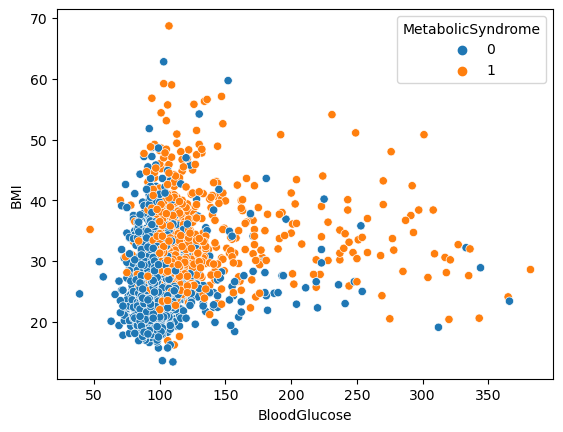

In [24]:
sns.scatterplot(data=df, x='BloodGlucose', y = 'BMI', hue= 'MetabolicSyndrome');

#### This shows the relationship for BMI and Blood Glucose. Again, levels tested above 100 are mostly positive metabolic syndrome. However, this plot shows most positives also have a BMI above 30 as well. 

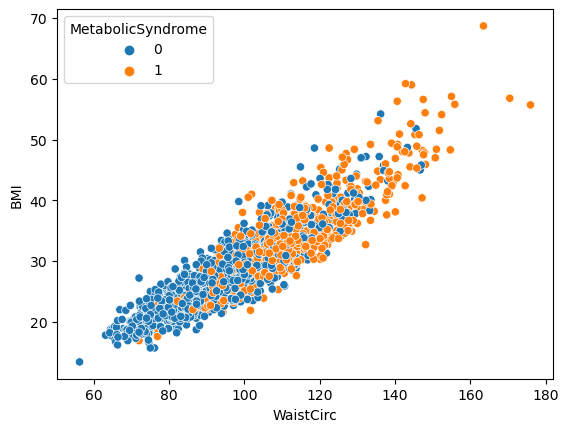

In [25]:
sns.scatterplot(data=df, x='WaistCirc', y = 'BMI', hue= 'MetabolicSyndrome');

#### Here we have a clear cut examination for BMI and waist circumference. This shows what the heat map told me for the correlation between these two features and metabolic syndrome development. Simply put, the waist circumference and BMI will increase together and this will increase the chances of developing metabolic syndrome.

### **Lineplots describing what I could see from the scatterplots**

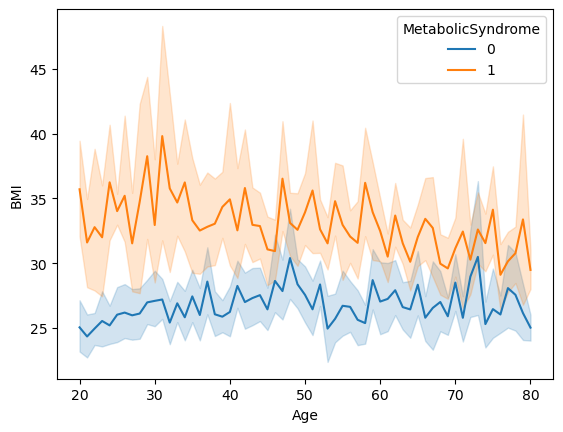

In [284]:
sns.lineplot(data=df, x='Age', y='BMI', hue='MetabolicSyndrome');

#### Targeting the BMI, above 30 is where the positive metabolic syndrome cases are at in the line plot. I can also see that age is not much of determining factor from this small data collection.

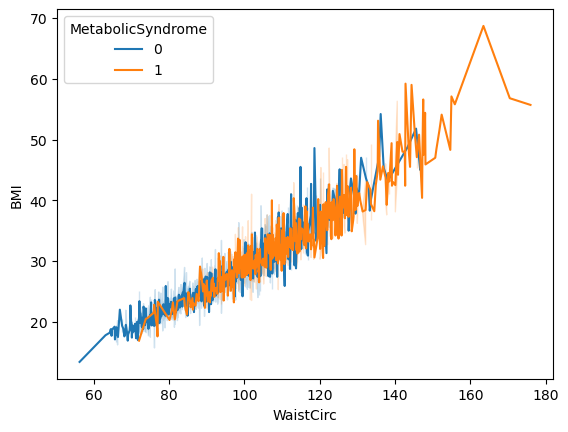

In [27]:
sns.lineplot(data=df, y='BMI', x='WaistCirc', hue='MetabolicSyndrome');

#### Again, showing the relationship between BMI and waist circumference hand in hand.

# Validation Split

In [106]:
# Create copy of data
df2 = df1.copy()

In [33]:
# Display balance for target before split
df['MetabolicSyndrome'].value_counts(normalize=True)

0    0.657643
1    0.342357
Name: MetabolicSyndrome, dtype: float64

#### The target data is imbalanced; only 34% are positive cases for metabolic syndrome. Along with the lack of correlation between target and features, the binary imbalance in such a small data set will likely create unreliable models. 

In [34]:
# Define target(y) and features (X)

X = df.drop(columns=['seqn', 'MetabolicSyndrome'])
y = df['MetabolicSyndrome']
             
# Split the data             
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
263,46,Female,Married,8200.0,White,124.0,40.8,0,18.47,3.3,140,53,198
2073,34,Male,Separated,3500.0,MexAmerican,86.2,24.5,0,16.14,6.1,114,83,60
632,33,Female,Married,3500.0,MexAmerican,75.0,25.0,0,11.54,3.4,97,44,60
1732,49,Female,Married,9000.0,Hispanic,95.7,33.3,0,3.81,2.7,89,51,139
765,30,Male,Married,9000.0,Asian,75.7,21.9,0,7.76,7.1,81,58,394
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,21,Male,Single,5400.0,MexAmerican,116.7,35.0,0,2.76,7.4,100,37,173
1095,40,Male,Married,9000.0,Asian,93.3,27.1,0,3.51,5.5,89,52,83
1130,80,Female,Married,3500.0,White,90.0,26.2,0,13.67,4.1,202,56,69
1294,61,Male,Married,2000.0,Black,110.8,30.5,1,138.79,7.1,108,53,146


In [35]:
# Diplay test data information
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601 entries, 685 to 1934
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            601 non-null    int64  
 1   Sex            601 non-null    object 
 2   Marital        548 non-null    object 
 3   Income         573 non-null    float64
 4   Race           601 non-null    object 
 5   WaistCirc      577 non-null    float64
 6   BMI            597 non-null    float64
 7   Albuminuria    601 non-null    int64  
 8   UrAlbCr        601 non-null    float64
 9   UricAcid       601 non-null    float64
 10  BloodGlucose   601 non-null    int64  
 11  HDL            601 non-null    int64  
 12  Triglycerides  601 non-null    int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 65.7+ KB


In [36]:
# Diplay train data information
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 263 to 860
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            1800 non-null   int64  
 1   Sex            1800 non-null   object 
 2   Marital        1645 non-null   object 
 3   Income         1711 non-null   float64
 4   Race           1800 non-null   object 
 5   WaistCirc      1739 non-null   float64
 6   BMI            1778 non-null   float64
 7   Albuminuria    1800 non-null   int64  
 8   UrAlbCr        1800 non-null   float64
 9   UricAcid       1800 non-null   float64
 10  BloodGlucose   1800 non-null   int64  
 11  HDL            1800 non-null   int64  
 12  Triglycerides  1800 non-null   int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 196.9+ KB


In [37]:
# Display balance for target (y)
print(f'Training data:\n {y_train.value_counts(normalize=True)}')
print('\n')
print(f'Testing data:\n {y_test.value_counts(normalize=True)}')

Training data:
 0    0.656667
1    0.343333
Name: MetabolicSyndrome, dtype: float64


Testing data:
 0    0.660566
1    0.339434
Name: MetabolicSyndrome, dtype: float64


### Create a preprocessor

In [38]:
# Create column selectors
cat_sel = make_column_selector(dtype_include = 'object')
num_sel = make_column_selector(dtype_include = 'number')

In [39]:
# Create imputers
cat_imp = SimpleImputer(strategy='constant')
num_imp = SimpleImputer(strategy='median')

- This is a small data set and complex imputation is not required to fill such a small percentage of missing values for the demonstrative purposes of the project. 
- I chose to use a constant strategy to fill missing values with categorical data. This will fill the NaN with Missing_value. I don't want strategies like most frequent making correlations with marital status for example.  
- The correlation between developing metabolic syndrome and the categorical columns is so low, I feel comfortable with the constant strategy.
- I chose a median strategy for numeric data because the percent of missing data is low and the outliers would have affected the mean too much.   


In [40]:
# Create scaler
scaler = StandardScaler()

In [41]:
# Create one hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [42]:
# Create pipelines
cat_pipe = make_pipeline(cat_imp, ohe)
num_pipe = make_pipeline(num_imp, scaler)

In [43]:
# Create tuples
cat_tup = (num_pipe, num_sel)
num_tup = (cat_pipe, cat_sel)

In [44]:
# Create preprocessor
preprocessor = make_column_transformer(num_tup, cat_tup, remainder='drop')

## Random forest model

In [91]:
# Create random forest model
rf = RandomForestClassifier(random_state=42)
rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001776C1869A0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001776C186FA0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [92]:
# Create variables for predictions
rf_pred_test = rf_pipe.predict(X_test)
rf_pred_train = rf_pipe.predict(X_train)

In [93]:
# Print base scores for random forest model
print(f'Train score: {accuracy_score(y_train, rf_pred_train):.3f}')
print(f'Test score: {accuracy_score(y_test, rf_pred_test):.3f}')

Train score: 1.000
Test score: 0.880


In [94]:
# Display classification report 
test_rf_report = classification_report(y_test, rf_pred_test)
train_rf_report = classification_report(y_train, rf_pred_train)
print('Test\n', test_rf_report)
print('Train\n', train_rf_report)

Test
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       397
           1       0.85      0.78      0.82       204

    accuracy                           0.88       601
   macro avg       0.87      0.86      0.86       601
weighted avg       0.88      0.88      0.88       601

Train
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1182
           1       1.00      1.00      1.00       618

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



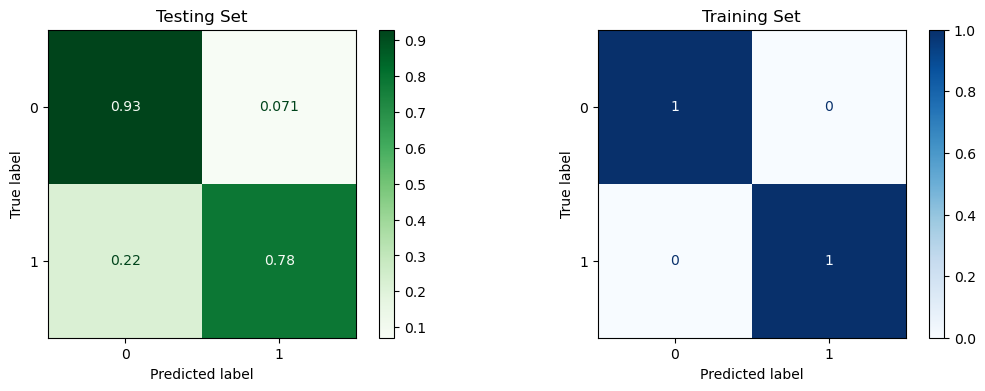

In [95]:
# Display confusion matrix for random forest model
fig, axes = plt.subplots(ncols=2, figsize=(13, 4))
ConfusionMatrixDisplay.from_predictions(y_test, rf_pred_test, ax=axes[0], 
                                        normalize='true', cmap='Greens');
ConfusionMatrixDisplay.from_predictions(y_train, rf_pred_train, ax=axes[1],
                                        normalize='true', cmap='Blues');

axes[0].set_title('Testing Set')
axes[1].set_title('Training Set');

### Tuning random forest model

In [55]:
# Create and run grid search
param = {'randomforestclassifier__max_depth': [None, 1, 2, 3, 4],
        'randomforestclassifier__min_samples_leaf': [1, 3, 15, 20, 26],
        'randomforestclassifier__min_samples_split': [2, 10, 50, 100, 150]}

pd.DataFrame(param).T

,0,1,2,3,4
randomforestclassifier__max_depth,NaN,1.0,2.0,3.0,4.0
randomforestclassifier__min_samples_leaf,1.0,3.0,15.0,20.0,26.0
randomforestclassifier__min_samples_split,2.0,10.0,50.0,100.0,150.0


In [246]:
# Fit grid search on the train
grid_search = GridSearchCV(rf_pipe, param)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001776C1869A0>),
                                                                        ('pipeline-2',
                                                                         Pip...
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001776C186FA0>)])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'randomforestclassifier__max_depth': [None, 1, 2, 3,
                                                               4],
                         'randomforestclassifier__min_samples_leaf': [1, 3, 15,
                                                                      20, 26],
                         'randomforestclassifier__min_samples_split': [2, 10,
                                                                       50, 100,
                                                                       150]})

In [57]:
# Display best parameters
grid_search.best_params_

{'randomforestclassifier__max_depth': None,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 10}

In [78]:
# Run grid search again to see if finer tuning produces better match
param2 = {'randomforestclassifier__max_depth': [None, 6, 7, 8, 9],
          'randomforestclassifier__min_samples_leaf': [1, 2, 4, 5, 6],
          'randomforestclassifier__min_samples_split': [3, 5, 10, 15],
          'randomforestclassifier__n_estimators': [5, 50, 100]}
 
grid_search2 = GridSearchCV(rf_pipe, param2)
grid_search2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001776C1869A0>),
                                                                        ('pipeline-2',
                                                                         Pip...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001776C186FA0>)])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'randomforestclassifier__max_depth': [None, 6, 7, 8,
                                                               9],
                         'randomforestclassifier__min_samples_leaf': [1, 2, 4,
                                                                      5, 6],
                         'randomforestclassifier__min_samples_split': [3, 5, 10,
                                                                       15],
                         'randomforestclassifier__n_estimators': [5, 50, 100]})

In [80]:
# Fit and score the tuned model
best_model = grid_search2.best_estimator_
best_model.fit(X_train, y_train)
best_model.score(X_test, y_test)

0.8801996672212978

In [81]:
# Create predictors
test_best = best_model.predict(X_test)
train_best = best_model.predict(X_train)

In [82]:
# Display classification reort for tuned random forest
test_report = classification_report(y_test, test_best)
train_report = classification_report(y_train, train_best)
print('Test\n', test_report)
print('Train\n', train_report)

Test
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       397
           1       0.86      0.77      0.81       204

    accuracy                           0.88       601
   macro avg       0.87      0.85      0.86       601
weighted avg       0.88      0.88      0.88       601

Train
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1182
           1       1.00      0.98      0.99       618

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800



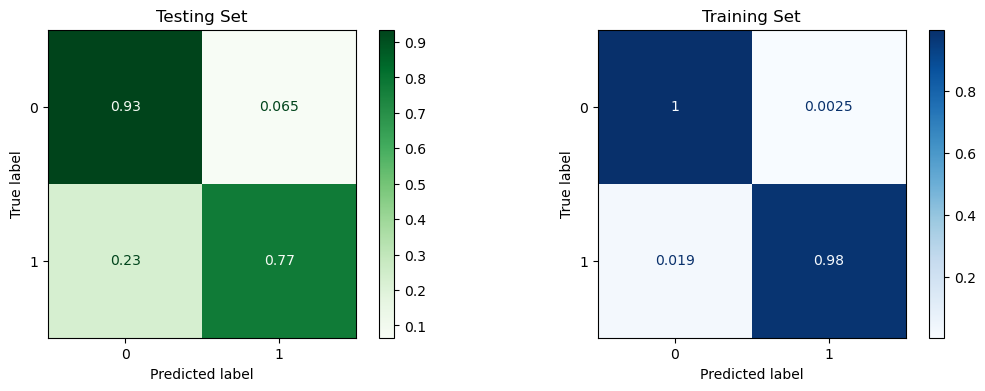

In [83]:
# Create confusion matrix for tuned random forest on train and test sets
fig, axes = plt.subplots(ncols=2, figsize=(13, 4))
ConfusionMatrixDisplay.from_predictions(y_test, test_best, ax=axes[0], 
                                        normalize='true', cmap='Greens');
ConfusionMatrixDisplay.from_predictions(y_train, train_best, ax=axes[1],
                                        normalize='true', cmap='Blues');

axes[0].set_title('Testing Set')
axes[1].set_title('Training Set');

#### My tuning for the random forest model did not produce better results.

### Using PCA with random forest

In [87]:
# Create random forest model with pca
pca = PCA(n_components=0.95)
rf_pca_pipe = make_pipeline(preprocessor, pca, rf)
rf_pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001776C1869A0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001776C186FA0>)])),
                ('pca', PCA(n_components=0.95)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [89]:
# Create variables for predictions
rf_pcapred_test = rf_pca_pipe.predict(X_test)
rf_pcapred_train = rf_pca_pipe.predict(X_train)

In [90]:
# Print base scores for random forest model
print(f'Train score: {accuracy_score(y_train, rf_pcapred_train):.3f}')
print(f'Test score: {accuracy_score(y_test, rf_pcapred_test):.3f}')

Train score: 1.000
Test score: 0.810


#### Although training set performed at 1.0, the test score is significantly lower than the baseline random forest model.

## KNNeighbors model

In [65]:
# Create base KNN model
knn = KNeighborsClassifier()
# Create pipeline
knn_pipe = make_pipeline(preprocessor, knn)
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001776C1869A0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001776C186FA0>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [66]:
# Create predictor variables
knn_test_pred = knn_pipe.predict(X_test)
knn_train_pred = knn_pipe.predict(X_train)

In [67]:
# Display scores for base KNN model
acc_score = knn_pipe.score(X_test, y_test)
print(f'knn accuracy: {acc_score:.3f}')
print(f'knn test accuracy', accuracy_score(y_test, knn_test_pred))
print(f'knn train accuracy', accuracy_score(y_train, knn_train_pred))

knn accuracy: 0.789
knn test accuracy 0.7886855241264559
knn train accuracy 0.865


In [68]:
# Display classification report for KNN model
test_knn_report = classification_report(y_test, knn_test_pred)
train_knn_report = classification_report(y_train, knn_train_pred) 
print('Test\n', test_knn_report)
print('Train\n', train_knn_report)

Test
               precision    recall  f1-score   support

           0       0.81      0.88      0.85       397
           1       0.73      0.61      0.66       204

    accuracy                           0.79       601
   macro avg       0.77      0.74      0.75       601
weighted avg       0.78      0.79      0.78       601

Train
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      1182
           1       0.84      0.75      0.79       618

    accuracy                           0.86      1800
   macro avg       0.86      0.84      0.85      1800
weighted avg       0.86      0.86      0.86      1800



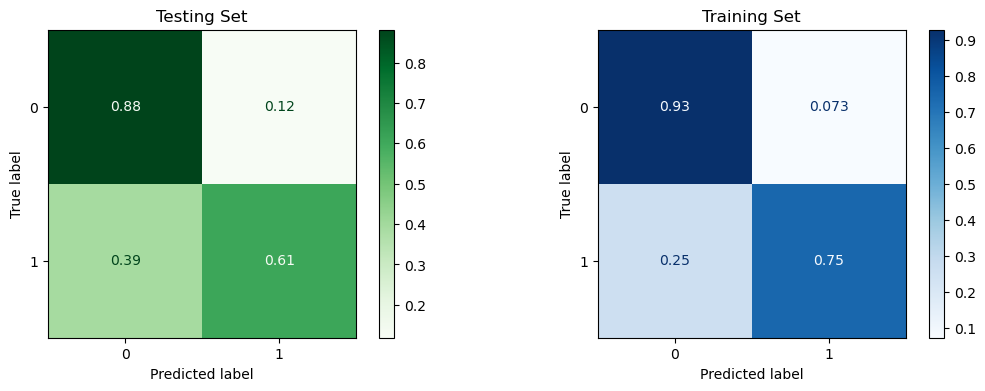

In [69]:
# Display confusion matrix for base KNN model on train and test sets.
fig, axes = plt.subplots(ncols=2, figsize=(13, 4))
ConfusionMatrixDisplay.from_predictions(y_test, knn_test_pred, ax=axes[0], 
                                        normalize='true', cmap='Greens');
ConfusionMatrixDisplay.from_predictions(y_train, knn_train_pred , ax=axes[1],
                                        normalize='true', cmap='Blues');

axes[0].set_title('Testing Set')
axes[1].set_title('Training Set');

#### The KNN model is producing a significant amount of error.

### Tuning KNNeighbors model

In [70]:
# Create range for 'k' and paramaters to run grid search through 'k'
params = {'kneighborsclassifier__n_neighbors': range(1, 50),
          'kneighborsclassifier__weights': ['distance', 'uniform']}

In [71]:
# Run gridsearch 
grid_knn = GridSearchCV(knn_pipe, params)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001776C1869A0>),
                                                                        ('pipeline-2',
                                                                         Pip...teps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001776C186FA0>)])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 50),
                         'kneighborsclassifier__weights': ['distance',
                                                           'uniform']})

In [72]:
# Fit best KNN estimators on train
best_knn = grid_knn.best_estimator_
best_knn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001776C21BBB0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001776C21BF10>)])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=26, weights='distance'))])

In [73]:
# Create tuned predictor variables 
test_knn = best_knn.predict(X_test)
train_knn = best_knn.predict(X_train)

In [74]:
# Print the tuned scores for test and train
print(f'knn tuned test accuracy: {accuracy_score(y_test, test_knn):.3f}')
print(f'knn tuned train accuracy: {accuracy_score(y_train, train_knn):.3f}')

knn tuned test accuracy: 0.807
knn tuned train accuracy: 1.000


In [76]:
# Display classification report for tuned KNN model
knn_test_report = classification_report(y_test, test_knn)
knn_train_report = classification_report(y_train, train_knn)
print('Test\n', knn_test_report)
print('Train\n', knn_train_report)

Test
               precision    recall  f1-score   support

           0       0.82      0.91      0.86       397
           1       0.78      0.61      0.68       204

    accuracy                           0.81       601
   macro avg       0.80      0.76      0.77       601
weighted avg       0.80      0.81      0.80       601

Train
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1182
           1       1.00      1.00      1.00       618

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



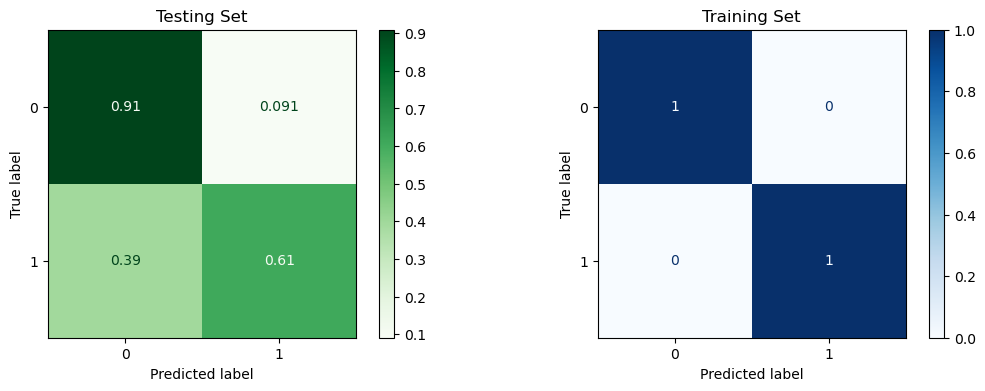

In [77]:
# Display confusion matrix for tuned KNN model on train and test sets
fig, axes = plt.subplots(ncols=2, figsize=(13, 4))
ConfusionMatrixDisplay.from_predictions(y_test, test_knn, ax=axes[0], 
                                        normalize='true', cmap='Greens');
ConfusionMatrixDisplay.from_predictions(y_train, train_knn , ax=axes[1],
                                        normalize='true', cmap='Blues');

axes[0].set_title('Testing Set')
axes[1].set_title('Training Set');

#### Slight improvements after tuning but the not better than the base random forest model.

## Logistic regression model

In [96]:
# Create scaler, pipeline, and fit to train
logr = LogisticRegression(random_state=42)
logr_pipe = make_pipeline(preprocessor, logr)
logr_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001776C1869A0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001776C186FA0>)])),
                ('logisticregression', LogisticRegression(random_state=42))])

In [97]:
# Create variables for predictions
logr_pred_test = logr_pipe.predict(X_test)
logr_pred_train = logr_pipe.predict(X_train)

In [98]:
# Print base scores for logistic regression model
print(f'Train score: {accuracy_score(y_train, logr_pred_train):.3f}')
print(f'Test score: {accuracy_score(y_test, logr_pred_test):.3f}')

Train score: 0.856
Test score: 0.829


In [100]:
# Display tuned classification report
test_logr_report = classification_report(y_test, logr_pred_test)
train_logr_report = classification_report(y_train, logr_pred_train)
print('Test\n', test_logr_report)
print('Train\n', train_logr_report)

Test
               precision    recall  f1-score   support

           0       0.84      0.91      0.88       397
           1       0.80      0.67      0.73       204

    accuracy                           0.83       601
   macro avg       0.82      0.79      0.80       601
weighted avg       0.83      0.83      0.82       601

Train
               precision    recall  f1-score   support

           0       0.87      0.92      0.89      1182
           1       0.82      0.74      0.78       618

    accuracy                           0.86      1800
   macro avg       0.85      0.83      0.84      1800
weighted avg       0.85      0.86      0.85      1800



#### No visual needed, the scores are much lower than previous models.

### Tuning logistic regression model

In [102]:
# Create and run gridsearch for logistic regression
grid = {'logisticregression__penalty': ['l1','l2'],
        'logisticregression__C': [.0001, .001, .01, .1, 1, 10, 100, 1000, 10000],
        'logisticregression__solver': ['liblinear'],
        'logisticregression__max_iter': [100, 500, 1000]}

model_logr = GridSearchCV(logr_pipe, grid)
model_logr.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001776C1869A0>),
                                                                        ('pipeline-2',
                                                                         Pip...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001776C186FA0>)])),
                                       ('logisticregression',
                                        LogisticRegression(random_state=42))]),
             param_grid={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   10, 100, 1000, 10000],
                         'logisticregression__max_iter': [100, 500, 1000],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear']})

In [103]:
# Fit the best logistic regression model
best_modellr = model_logr.best_estimator_
best_modellr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001776F16B2B0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001776F16B520>)])),
                ('logisticregression',
                 LogisticRegression(C=0.1, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [104]:
# Display scores for tuned logistic regression
print(f'Train score: {best_modellr.score(X_train, y_train):.3f}')
print(f'Test score: {best_modellr.score(X_test, y_test):.3f}')

Train score: 0.846
Test score: 0.824


#### The default random forest model performed well on test set and a 1.0 on the training set. Further tuning could yield a slightly better result on the test set, but not with the methods and parameters I used.

# Feature Engineering

- I will experiment with the features and make every value binary. I will use what are considered normal ranges for health related features and group the others as I see fit. 
- This will cause data leakage but I am not looking for a better model, only searching for other possibilities within the data.

#### **Sources cited for normal ranges**
- https://www.healthline.com/health/high-cholesterol/levels-by-age#adults
- https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/in-depth/triglycerides/art-20048186
- https://my.clevelandclinic.org/health/diagnostics/12363-blood-glucose-test
- https://www.medicalnewstoday.com/articles/how-to-measure-your-waist
- https://www.heart.org/en/healthy-living/healthy-eating/losing-weight/bmi-in-adults
- https://www.kidney.org/content/kidney-failure-risk-factor-urine-albumin-to-creatinine-ration-uacr

In [167]:
# Create copy of data
df3 = df2.copy()

In [188]:
# Change column names to lowercase
df3= df3.rename(columns=str.lower)

In [186]:
# Convert centimeters to inches for waist circumference
df3['waistcirc'] = df3['waistcirc'].apply(lambda x: (x/2.54))

In [189]:
# Compare to original df to make sure conversion is correct
df3.value_counts('waistcirc')

waistcirc
38.188976    23
39.370079    17
40.551181    14
38.976378    13
35.433071    12
             ..
45.905512     1
45.944882     1
46.102362     1
46.259843     1
69.291339     1
Length: 635, dtype: int64

In [170]:
# Compare to copied df3 to make sure conversion is correct
df.value_counts('WaistCirc')

WaistCirc
97.0     23
100.0    17
103.0    14
99.0     13
90.0     12
         ..
116.6     1
116.7     1
117.1     1
117.5     1
176.0     1
Length: 635, dtype: int64

### Make new columns to create new dataframe

In [191]:
# Change hdl to boolean
df3['low_hdl'] = df3['hdl']<=60

In [194]:
# Change waistcirc to boolean
df3['large_waist'] = df3['waistcirc']>37

In [196]:
# Change bmi to boolean
df3['high_bmi'] = df3['bmi']>29

In [198]:
# Change bloodglucose to boolean
df3['glucose_above_99'] = df3['bloodglucose']>99

In [200]:
# Change triglycerides to boolean
df3['trigly_above_150'] = df3['triglycerides']>150

In [203]:
# Change sex to binary
df3 = df3.replace({'sex': {'Male': '0', 'Female': '1'}})
df3.rename(columns={'sex':'isfemale'}, inplace=True)

In [208]:
# Change marital to boolean
df3['ismarried'] = df3['marital']=='Married'

In [211]:
# Change race to boolean
df3['iswhite'] = df3['race']=='White'

In [226]:
# Change age to boolean
df3['age_above_40'] = df3['age']>40

In [213]:
# Change uricacid to boolean
df3['uricacid_above_6'] = df3['uricacid']>6

In [222]:
# Change albumninuria to boolean
df3['normal_albuminuria'] = df3['albuminuria']==0

In [224]:
# Change uralbcr to boolean
df3['normal_uralbcr'] = df3['uralbcr']<=30

In [219]:
# Rename the colums to reflect what is true
df3.rename(columns={'high_bmi':'bmi_above_29', 'large_waist' :
                   'waist_above_37in', 'low_hdl': 'hdl_below_61'}, 
          inplace=True)

In [231]:
# Drop all non-boolean columns
df3.drop(['seqn', 'marital', 'income', 'race', 'waistcirc', 'bmi', 'uricacid',
         'bloodglucose', 'hdl', 'triglycerides', 'uralbcr', 'albuminuria', 
          'age'], axis=1, inplace=True)

In [229]:
# Change all boolean values to binary
df3.hdl_below_61 = df3.hdl_below_61.replace({True: 1, False: 0})
df3.waist_above_37in = df3.waist_above_37in.replace({True: 1, False: 0})
df3.bmi_above_29 = df3.bmi_above_29.replace({True: 1, False: 0})
df3.glucose_above_99 = df3.glucose_above_99.replace({True: 1, False: 0})
df3.trigly_above_150 = df3.trigly_above_150.replace({True: 1, False: 0})
df3.ismarried = df3.ismarried.replace({True: 1, False: 0})
df3.iswhite = df3.iswhite.replace({True: 1, False: 0})
df3.uricacid_above_6 = df3.uricacid_above_6.replace({True: 1, False: 0}) 
df3.normal_albuminuria = df3.normal_albuminuria.replace({True: 1, False: 0}) 
df3.normal_uralbcr = df3.normal_uralbcr.replace({True: 1, False: 0}) 
df3.age_above_40 = df3.age_above_40.replace({True: 1, False: 0})                                                

In [232]:
# Display experimental dataframe
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   isfemale            2401 non-null   object
 1   metabolicsyndrome   2401 non-null   int32 
 2   hdl_below_61        2401 non-null   int64 
 3   waist_above_37in    2401 non-null   int64 
 4   bmi_above_29        2401 non-null   int64 
 5   glucose_above_99    2401 non-null   int64 
 6   trigly_above_150    2401 non-null   int64 
 7   ismarried           2401 non-null   int64 
 8   iswhite             2401 non-null   int64 
 9   uricacid_above_6    2401 non-null   int64 
 10  normal_albuminuria  2401 non-null   int64 
 11  normal_uralbcr      2401 non-null   int64 
 12  age_above_40        2401 non-null   int64 
dtypes: int32(1), int64(11), object(1)
memory usage: 234.6+ KB


In [233]:
# Change the isfemale data type to an integer
df3['isfemale'] = df3['isfemale'].astype(int)

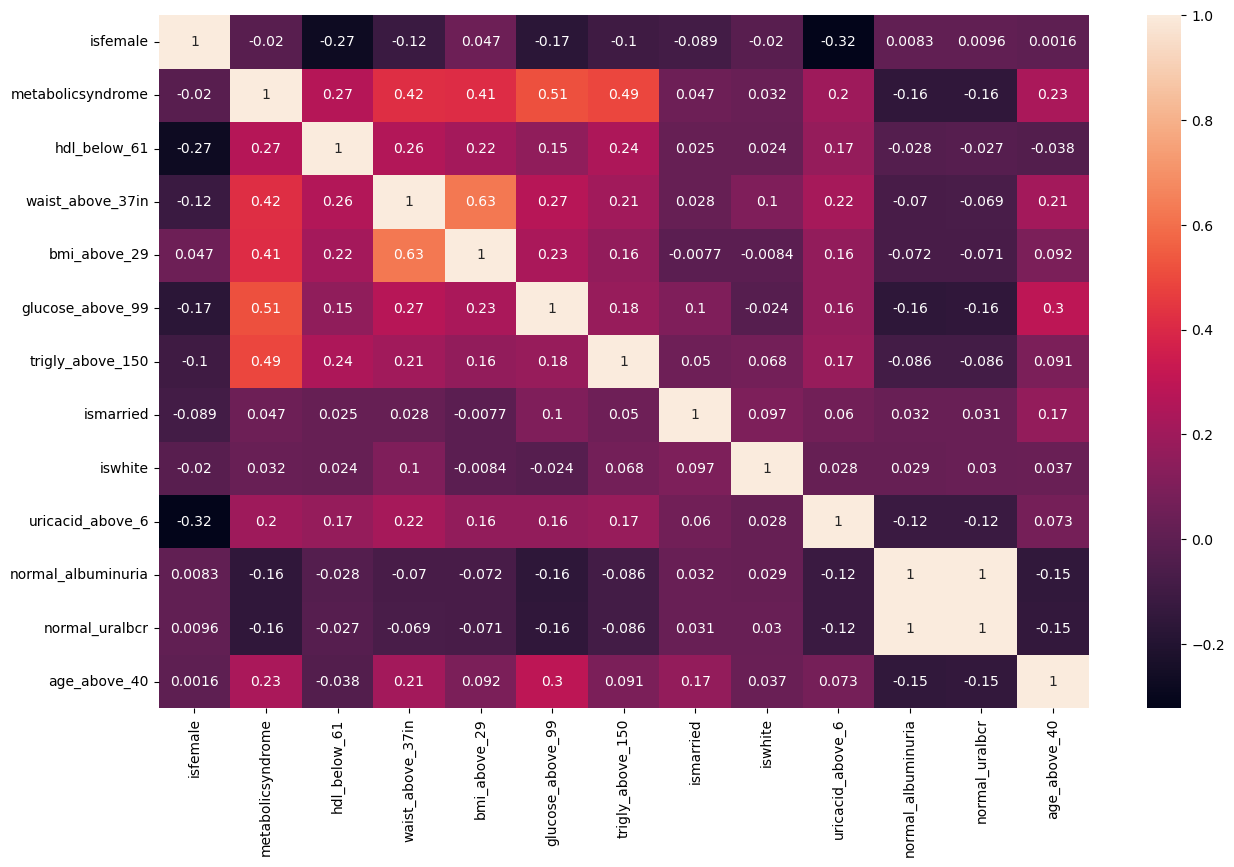

In [249]:
# Display heatmap
corr3 = df3.corr()
plt.figure(figsize = (15, 9))
sns.heatmap(corr3, annot=True);

### From the heat map above, I can see that there is not much change in correlation from the original dataset. This tells me models ran on the experimental data won't show much difference either. 

# Experimental models

In [236]:
# Define target(y) and features (X)

X = df3.drop(columns=['metabolicsyndrome'])
y = df3['metabolicsyndrome']
             
# Split the data             
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train

,isfemale,hdl_below_61,waist_above_37in,bmi_above_29,glucose_above_99,trigly_above_150,ismarried,iswhite,uricacid_above_6,normal_albuminuria,normal_uralbcr,age_above_40
263,1,1,1,1,1,1,1,1,0,1,1,1
2073,0,0,0,0,1,0,0,0,1,1,1,0
632,1,1,0,0,0,0,1,0,0,1,1,0
1732,1,1,1,1,0,0,1,0,0,1,1,1
765,0,1,0,0,0,1,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0,1,1,1,1,1,0,0,1,1,1,0
1095,0,1,0,0,0,0,1,0,0,1,1,0
1130,1,1,0,0,1,0,1,1,0,1,1,1
1294,0,1,1,1,1,0,1,0,1,0,0,1


#### I will not use a preprocessor for this experiment. Scaling is not needed and the missing values were all changed to a 0 or false.

In [237]:
# Create random forest model
rf3 = RandomForestClassifier(random_state=42)
rf3.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [238]:
# Create variables for predictions
rf3_pred_test = rf3.predict(X_test)
rf3_pred_train = rf3.predict(X_train)

In [239]:
# Print base scores for random forest model
print(f'Train score: {accuracy_score(y_train, rf3_pred_train):.3f}')
print(f'Test score: {accuracy_score(y_test, rf3_pred_test):.3f}')

Train score: 0.912
Test score: 0.840


In [240]:
# Create base model
knn3 = KNeighborsClassifier()
# Create pipeline
knn3.fit(X_train, y_train)

KNeighborsClassifier()

In [241]:
# Create variables for predictions
knn3_pred_test = knn3.predict(X_test)
knn3_pred_train = knn3.predict(X_train)

In [242]:
# Print base scores for random forest model
print(f'Train score: {accuracy_score(y_train, knn3_pred_train):.3f}')
print(f'Test score: {accuracy_score(y_test, knn3_pred_test):.3f}')

Train score: 0.876
Test score: 0.834


In [243]:
# Create scaler, pipeline, and fit to train
logr3 = LogisticRegression(random_state=42)
logr3.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [244]:
# Create variables for predictions
logr3_pred_test = logr3.predict(X_test)
logr3_pred_train = logr3.predict(X_train)

In [245]:
# Print base scores for random forest model
print(f'Train score: {accuracy_score(y_train, logr3_pred_train):.3f}')
print(f'Test score: {accuracy_score(y_test, logr3_pred_test):.3f}')

Train score: 0.863
Test score: 0.862


#### **Everything after this text line is not part of the assingment, just things I wish to explore later.**

- From Wikipedia, the free encyclopedia:
  - Metabolic syndrome is a clustering of at least three of the following five medical conditions: abdominal obesity, high blood pressure, high blood sugar, high serum triglycerides, and low serum high-density lipoprotein (HDL).

In [120]:
#  to bins
low_HDL = pd.cut(df1['HDL'], bins = [0,60])
above_60 = pd.cut(df1['HDL'], bins = [61,160])

# Add the binned values as a new categorical feature
df1['LOW_HDL'] = low_HDL
df1['above_60_HDL'] = above_60

In [ ]:
#  to bins
low_BG = pd.cut(df1['BloodGlucose'], bins = [0,])
above_60 = pd.cut(df1['HDL'], bins = [61,160])

# Add the binned values as a new categorical feature
df1['LOW_HDL'] = low_HDL
df1['above_60_HDL'] = above_60

In [47]:
# This was experimental
'''sns.catplot(data=df, x='BloodGlucose', y='Age', hue='MetabolicSyndrome', 
            order=df['BloodGlucose'].value_counts().index, s= 3.5, kind='swarm');'''

"sns.catplot(data=df, x='BloodGlucose', y='Age', hue='MetabolicSyndrome', \n            order=df['BloodGlucose'].value_counts().index, s= 3.5, kind='swarm');"

In [48]:
# This plot is temporary, only for personal study right now.

#### what does the 0, 1, 2 mean?
"""sns.catplot(data=df, x='Albuminuria', y='Age', hue='MetabolicSyndrome', 
            order=df['Albuminuria'].value_counts().index, s= 3.5, kind='swarm');"""

"sns.catplot(data=df, x='Albuminuria', y='Age', hue='MetabolicSyndrome', \n            order=df['Albuminuria'].value_counts().index, s= 3.5, kind='swarm');"

In [124]:
df1.value_counts('above_60_HDL')

above_60_HDL
(61, 160]    607
dtype: int64

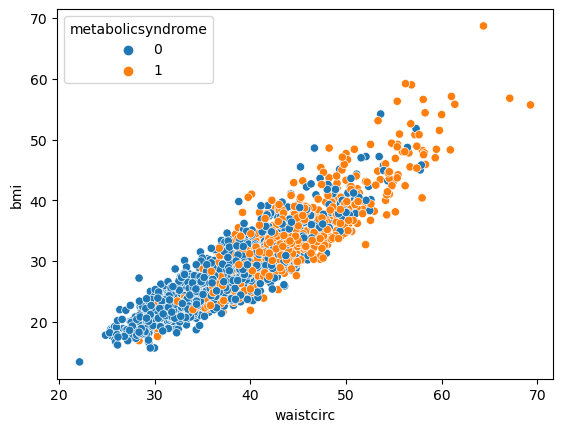

In [193]:
sns.scatterplot(data=df3, x='waistcirc', y = 'bmi', hue= 'metabolicsyndrome');

#### This data is showing the many factors that could be related to developing metabolic syndrome. The main features include: body mass index, waist circumference, triglycerides above 150, HDL cholesterol below 50 in women or 40 in men, established proteinurnia, uric acid levels, and elevated fasting blood sugar (100-125). These columns all represent measurements that qualified medical professionals use to obtain a snapshot of health. I will have to do further research on what the UrAlbCr column represents. Also, it seems to have no history of blood pressure measurements. Age, sex, marital status, income, race are all personal attributes and could play a factor even thought they seem less relevant at first glance. 
#### **The target is metabloic syndrome. It is a classification problem because we are determining whether or not someone does or does not develop said condition.**

#### There are 15 features and 2401 rows in the dataset.

Challenges include: the missing data, why the data set did not feature blood pressure, what is UrAlbCR, and is there a clear link to one or all of these factors for the patients who did develop metabolic syndrome?